In [1]:
import torch
import torch.nn as nn
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader, random_split

import matplotlib.pyplot as plt
import numpy as np

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DATA_FOLDER = "./util/FMNIST"

In [2]:
FMNIST = datasets.FashionMNIST(DATA_FOLDER, download=False, train=True)
train_img = FMNIST.data
train_label = FMNIST.targets

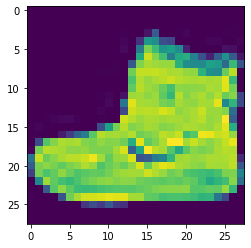

In [3]:
plt.imshow(train_img[0])

In [4]:
class toDataset(Dataset):
    def __init__(self, x, y):
        x = x.float() / 255 # normalisasi
        x = x.view(-1, 1, 28, 28) #(jumlah data point, 1 channel grayscale, h, w)
        self.x, self.y = x, y
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        x, y = self.x[idx], self.y[idx]
        return x.to(DEVICE), y.to(DEVICE)

In [72]:
from torch import optim
from sklearn.metrics import f1_score

def get_model():
    model = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.Conv2d(64, 128, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.Flatten(),
        nn.Linear(3200, 256),
        nn.ReLU(),
        nn.Linear(256, 10)
    ).to(DEVICE)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, optimizer


def train_batch(x, y, model, optim, loss_fn):
    model.train()
    y_pred = model(x)
    loss = loss_fn(y_pred, y)
    loss.backward()
    optim.step()
    optim.zero_grad()
    return loss.item()


def accuracy(x, y_true, model):
    model.eval()
    y_pred = model(x)
    is_correct = y_pred.argmax(dim=1) == y_true
    return is_correct.float().mean().item()

In [66]:
model, loss_fn, optimizer = get_model()
ds = toDataset(train_img, train_label)
EPOCH = 5

train_ds, test_ds = random_split(
    ds, [(int(len(train_img) * 0.8)), (int(len(train_img) * 0.2))])

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
test_dl = DataLoader(test_ds, shuffle=True,batch_size=32)

losses = []
accuracies = []
for epoch in range(EPOCH):
    loss = []
    acc = []
    for i, (x, y) in enumerate(iter(train_dl)):
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        batch_acc = accuracy(x, y, model)
        print(f"epoch {epoch} | batch {i} | loss {batch_loss} | acc {batch_acc}")
        acc.append(batch_acc)
        loss.append(batch_loss)
    accuracies.append(np.mean(acc))
    losses.append(np.mean(loss))


epoch 0 | batch 0 | loss 2.2919633388519287 | acc 0.3125
epoch 0 | batch 1 | loss 1.847367525100708 | acc 0.5
epoch 0 | batch 2 | loss 1.2426841259002686 | acc 0.6875
epoch 0 | batch 3 | loss 1.3165323734283447 | acc 0.4375
epoch 0 | batch 4 | loss 1.2183609008789062 | acc 0.375
epoch 0 | batch 5 | loss 0.984964907169342 | acc 0.3125
epoch 0 | batch 6 | loss 0.6066924333572388 | acc 0.5
epoch 0 | batch 7 | loss 1.0963075160980225 | acc 0.4375
epoch 0 | batch 8 | loss 0.634926974773407 | acc 0.34375
epoch 0 | batch 9 | loss 0.653313159942627 | acc 0.59375
epoch 0 | batch 10 | loss 1.540487289428711 | acc 0.375
epoch 0 | batch 11 | loss 0.9407211542129517 | acc 0.5625
epoch 0 | batch 12 | loss 0.7312726378440857 | acc 0.53125
epoch 0 | batch 13 | loss 0.5823004245758057 | acc 0.40625
epoch 0 | batch 14 | loss 1.206775188446045 | acc 0.59375
epoch 0 | batch 15 | loss 0.8246747255325317 | acc 0.5
epoch 0 | batch 16 | loss 0.5166538953781128 | acc 0.40625
epoch 0 | batch 17 | loss 0.7236276

Text(0, 0.5, 'loss')

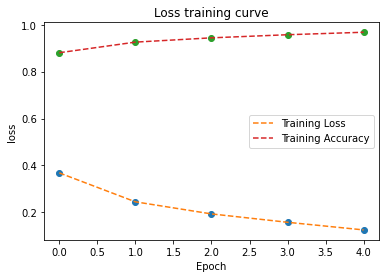

In [67]:
plt.title("Loss training curve")
plt.plot(range(EPOCH), losses, 'o')
plt.plot(range(EPOCH), losses, '--', label="Training Loss")
plt.plot(range(EPOCH), accuracies, 'o')
plt.plot(range(EPOCH), accuracies, '--', label="Training Accuracy")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("loss")

In [78]:
test_acc = []

for i, (x, y) in enumerate(iter(test_dl)):
    batch_acc = accuracy(x, y, model)
    test_acc.append(batch_acc)

print(f"Train Accuracy: {np.mean(accuracies)}")
print(f"Test Accuracy: {np.mean(test_acc)}")

Train Accuracy: 0.935225
Test Accuracy: 0.907
